<a href="https://colab.research.google.com/github/marianelia/tmp/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Solution_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Лагуткина |
|---------|--------|
| Группа  | 6      |

Вариант: 1

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

## Нейронная сеть 
### Установка библиотек и настройка среды


In [1]:
import torch
import numpy as np
import pandas
import torchvision.utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

1.11.0+cu113


### Устанавливаем вычислительное устройство

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def print_device():
  print('Doing computations on '+device)

## Нейросеть


In [4]:

#TODO перписать в свою 
class Perceptron_solution_pytorch(torch.nn.Module):
    def __init__(self,learning_rate=0.1,epochs=10, layers=[], func=torch.nn.Tanh(), 
                 loss_func=torch.nn.functional.binary_cross_entropy_with_logits):
        super().__init__()
        self.learning_rate=learning_rate
        self.layers=layers
        self.func=func
        self.epochs=epochs
        self.loss_function=loss_func
        self.level=0
    
    def print_format(self, msg, level=-1):
        if level == -1:
            level = self.level
        print("  "*level + msg)
        
    def training(self, X, Y):
        self.create(X,Y)
        self.level = 0
        self.print_format("Network Training:") #!!!!!!
        self.level += 1
        
        val_x = torch.tensor(np.array(X).astype(np.float32))
        val_y = []
        for y in Y:
            val = np.zeros(self.classes_count)
            for i in range(10):
                val[i] = 1 if i == y else 0
            val_y.append(val.copy().astype(np.float32))
        dataset = torch.utils.data.TensorDataset(val_x,torch.tensor(val_y,dtype=torch.float32))
        dataloader = torch.utils.data.DataLoader(dataset,batch_size=16)
        #оптимизация
        optim = torch.optim.Adam(self.net.parameters(),lr=self.learning_rate)
        for epoch in range(1, self.epochs+1):
            for (x,y) in dataloader:
                z = self.net(x)
                loss = self.loss_function(z,y)
                optim.zero_grad()
                loss.backward()
                optim.step()
            acc = self.accuracy(X,Y)
            self.print_format("Epoch {} of {}: loss : {}, accuracy : {}".format(epoch, self.epochs,loss,acc))
        return self
        
    def create(self, X,Y):
        self.level=0
        #настройки для вывода параметров пользователю
        layers_tmp = self.layers.copy()
        layers_tmp.insert(0, len(X[0]))
        layers_tmp.append(len(np.unique(Y)))
        self.classes_count = layers_tmp[-1]
        module_layers = []
        self.print_format("Network Training:")
        self.level += 1
        self.print_format("In | {}".format(layers_tmp[0]))
        self.print_format("Out | {}".format(layers_tmp[-1]))
        self.print_format("Hidden layers    | {}".format(len(layers_tmp)-2))
        self.print_format("The breadth of hidden layers    | {}".format(self.layers))
        self.level -= 1
        #настройка сети, добавляем линейный слой и преобразовываем к значениям вероятностей
        for i in range(len(layers_tmp)-2):
            module_layers.append(torch.nn.Linear(layers_tmp[i], layers_tmp[i+1]))
            module_layers.append(self.func) 
        module_layers.append(torch.nn.Linear(layers_tmp[-2], layers_tmp[-1]))
        self.net = torch.nn.Sequential(*module_layers)
        return self    
    #точность         
    def accuracy(self, X, Y):
        val_x = torch.tensor(np.array(X).astype(np.float32))
        answer = self.net(val_x)
        results = [ np.argmax(v.detach().numpy()) for v in self.func(answer)]
        total_success = 0
        for res, y in zip(results, Y):
            if res == y:
                total_success += 1
        acc = total_success / len(Y)
        return acc
    def confusion_matrix(self, X, Y):
        val_x = torch.tensor(np.array(X).astype(np.float32))
        answer = self.net(val_x)
        results = [ np.argmax(v.detach().numpy()) for v in self.func(answer)]
        matrix = np.zeros((self.classes_count, self.classes_count), dtype=np.int32)
        for res, y in zip(results, Y):
            matrix[res][y] += 1
        return matrix

## Загрузка датасетов и подготовка данных

### Подготовительные функции

In [5]:
def convert_values(df):
    return np.array(df).astype(np.float32)/255


# TODO: замепнить на свои функции из 2.1
def count_of_keys(data):
    unique = np.unique(data)
    count = np.zeros(len(unique), dtype=np.int32)
    for v in data:
        count[v] += 1
    return count

def visualization_of_counts(df):
    counts = count_of_keys(df)
    plt.ylabel("Кол-во элементов в классе")
    plt.xlabel("Номер каждого класса")
    plt.bar(np.arange(len(counts)), counts)
    plt.xticks(np.arange(len(counts)), [i for i in range(len(counts))])

def print_data(labels, features, string :str, color_chart):
    visualization_of_counts(labels)
    print("{}".format(string))
    print("Number of elements in the dataset : {}".format(len(labels)))
    print("The number of attributes in the element : {}".format(len(features[0])))
    print()
    
def analyze(labels, features, string :str):
    visualization_of_counts(labels)
    print("Данные для [{}]".format(string))
    print("Количество элементов в датасете : {}".format(len(labels)))
    print("Количество атрибутов в элементе : {}".format(len(features[0])))
    print("Минимальное значение атрибута   : {}".format(np.min(features)))
    print("Максимальное значение атрибута  : {}".format(np.max(features)))
    print()

### MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

(60000, 784)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Данные для [Обучающая выборка из MNIST]
Количество элементов в датасете : 60000
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0

(10000, 784)
Данные для [Тестовая выборка из MNIST]
Количество элементов в датасете : 10000
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0



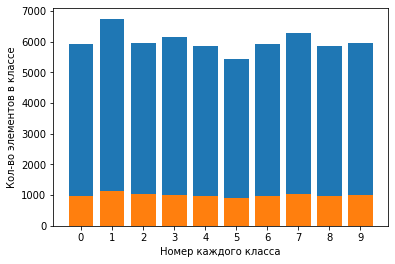

In [6]:
#transformations = transforms.Compose([
#  transforms.ToTensor(),
#  transforms.Normalize()                                         
#])
#TODO поставить свои функции
#Убрать кол-во элементов в атрибуте 
#Почему 28-то??
#TODO разбиение на выборки вынести в analize 
mnist_train = datasets.MNIST(root = './data/', train = True, transform = transforms.ToTensor(), download=True)
mnist_train_x = mnist_train.train_labels;
mnist_train_y_raw = mnist_train.train_data;

mnist_train_y = convert_values(mnist_train_y_raw)
mnist_train_y_reshape = mnist_train_y.reshape(60000, -1)
print(mnist_train_y_reshape.shape)

analyze(mnist_train_x, mnist_train_y_reshape, "Обучающая выборка из MNIST")

mnist_test = datasets.MNIST(root = './data/', train = False,transform = transforms.ToTensor(), download=True)
mnist_test_x = mnist_test.train_labels;
mnist_test_y_raw = mnist_test.train_data;

mnist_test_y = convert_values(mnist_test_y_raw)
mnist_test_y_reshape = mnist_test_y.reshape(10000, -1)
print(mnist_test_y_reshape.shape)
analyze(mnist_test_x, mnist_test_y_reshape, "Тестовая выборка из MNIST")

#delete:
#print(len(mnist_train_x))
#print(len(mnist_train_y[0]))
#print(np.min(mnist_train_y))
#print(np.max(mnist_train_y))
#print(MNIST_test)

### FasionMNIST

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fdata/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fdata/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fdata/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fdata/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fdata/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fdata/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fdata/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fdata/FashionMNIST/raw

torch.Size([60000])
(60000, 784)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Данные для [Обучающая выборка из Fashion MNIST]
Количество элементов в датасете : 60000
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./fdata/MNIST/raw/train-images-idx3-ubyte.gz to ./fdata/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./fdata/MNIST/raw/train-labels-idx1-ubyte.gz to ./fdata/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./fdata/MNIST/raw/t10k-images-idx3-ubyte.gz to ./fdata/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./fdata/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./fdata/MNIST/raw

(10000, 784)
Данные для [Тестовая выборка из Fashion MNIST]
Количество элементов в датасете : 10000
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0



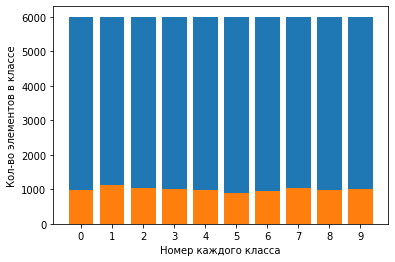

In [7]:
fashion_mnist_train = datasets.FashionMNIST(root = './fdata/', train = True, transform = transforms.ToTensor(), download=True)
fashion_mnist_train_x = fashion_mnist_train.train_labels;
fashion_mnist_train_y_raw = fashion_mnist_train.train_data;

fashion_mnist_train_y = convert_values(fashion_mnist_train_y_raw)
fashion_mnist_train_y_reshape = fashion_mnist_train_y.reshape(60000, -1)
##tmp
print(fashion_mnist_train_x.shape)
##
print(fashion_mnist_train_y_reshape.shape)

analyze(fashion_mnist_train_x, fashion_mnist_train_y_reshape, "Обучающая выборка из Fashion MNIST")

fashion_mnist_test = datasets.MNIST(root = './fdata/', train = False,transform = transforms.ToTensor(), download=True)
fashion_mnist_test_x = fashion_mnist_test.train_labels;
fashion_mnist_test_y_raw = fashion_mnist_test.train_data;

fashion_mnist_test_y = convert_values(fashion_mnist_test_y_raw)

fashion_mnist_test_y_reshape = fashion_mnist_test_y.reshape(10000, -1)
print(fashion_mnist_test_y_reshape.shape)
analyze(fashion_mnist_test_x, fashion_mnist_test_y_reshape, "Тестовая выборка из Fashion MNIST")


#print(fashion_mnist_train)
#(fashion_mnist_train_y_raw.shape)

### CIFAR-10

Датасет CIFAR-10 состоит из цветных изображений размером 32х32. Для картинок есть 10 категорий.

#### Загрузка датасета

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3072])
torch.Size([50000])
torch.Size([10000, 3072])
torch.Size([10000])
Данные для [Обчающая выборка CIFAR-10]
Количество элементов в датасете : 50000
Количество атрибутов в элементе : 3072
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0

Данные для [Тестовая выборка CIFAR-10]
Количество элементов в датасете : 10000
Количество атрибутов в элементе : 3072
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0



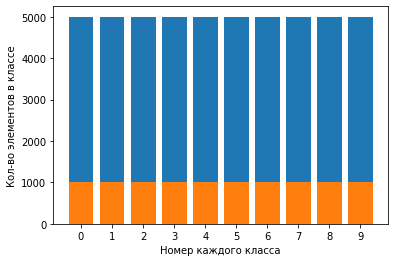

In [10]:
train_size = 50000
test_size = 10000

cfar_train = datasets.CIFAR10(root = './cdata/', train = True, transform = transforms.ToTensor(), download=True)
cfar_train_list =  torch.utils.data.DataLoader(cfar_train, batch_size=train_size, shuffle=True, num_workers=2)

cfar_test = datasets.CIFAR10(root = './cdata/', train = False,transform = transforms.ToTensor(), download=True)
cfar_test_list =  torch.utils.data.DataLoader(cfar_test, batch_size=test_size, shuffle=True, num_workers=2)

train_dataiter = iter(cfar_train_list)
cfar_train_images, cfar_train_labels = train_dataiter.next()
cfar_train_images_reshape = cfar_train_images.reshape(50000,-1)
print(cfar_train_images_reshape.shape)
print(cfar_train_labels.shape)

dataiter = iter(cfar_test_list)
cfar_test_images, cfar_test_labels = dataiter.next()
cfar_test_images_reshape = cfar_test_images.reshape(10000,-1)
print(cfar_test_images_reshape.shape)
print(cfar_test_labels.shape)

cfar_train_images_reshape_array= np.array(cfar_train_images_reshape)
cfar_test_images_reshape_array= np.array(cfar_test_images_reshape)

analyze(cfar_train_labels, cfar_train_images_reshape_array, "Обчающая выборка CIFAR-10")

analyze(cfar_test_labels, cfar_test_images_reshape_array, "Тестовая выборка CIFAR-10")

## Обучение и тестирование сети  